Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 'movies' table loaded into SQLite.
✅ Temporary 'worst_200_movies' table created.
✅ filtered_principals table loaded into SQLite.
✅ filtered_names table loaded into SQLite.
✅ Top culprits extracted and saved to CSV.


<ipython-input-10-200ec084a5aa>:91: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


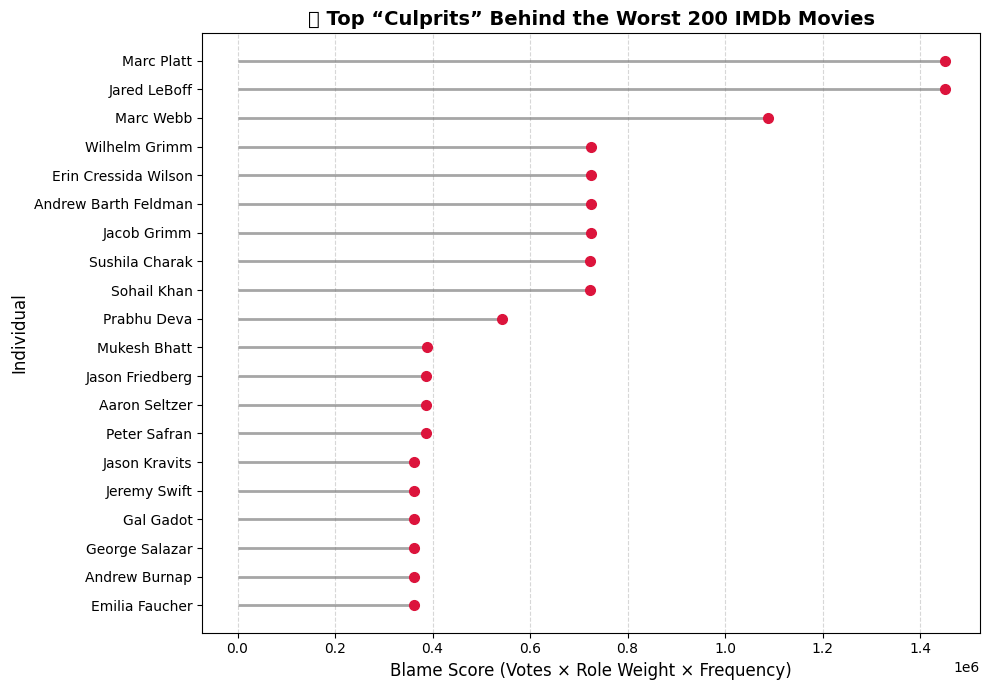

In [10]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Import libraries and connect to SQLite
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect('imdb_filtered.db')

# 3. Load merged movies file into SQLite
df_movies = pd.read_csv('/content/drive/MyDrive/IMDB_Data/filtered/merged_movies.csv')
df_movies.to_sql('movies', conn, if_exists='replace', index=False)
print("✅ 'movies' table loaded into SQLite.")

# 4. Create temporary 'worst_200_movies' table in SQLite
conn.execute("""
CREATE TEMP TABLE worst_200_movies AS
SELECT * FROM movies
ORDER BY averageRating ASC, numVotes DESC
LIMIT 200
""")
print("✅ Temporary 'worst_200_movies' table created.")

# 5. Load filtered principals and names CSVs into SQLite
df_principals = pd.read_csv('/content/drive/MyDrive/IMDB_Data/filtered/principals_filtered.csv')
df_principals.to_sql('filtered_principals', conn, if_exists='replace', index=False)
print("✅ filtered_principals table loaded into SQLite.")

df_names = pd.read_csv('/content/drive/MyDrive/IMDB_Data/filtered/names_filtered.csv')
df_names.to_sql('filtered_names', conn, if_exists='replace', index=False)
print("✅ filtered_names table loaded into SQLite.")

# 6. Define and run the weighted scoring SQL query
query_top_culprits = """
WITH role_weights AS (
  SELECT 'producer' AS role, 4 AS weight UNION ALL
  SELECT 'director', 3 UNION ALL
  SELECT 'writer', 2 UNION ALL
  SELECT 'actor', 1 UNION ALL
  SELECT 'actress', 1
),
merged AS (
  SELECT
    n.primaryName,
    LOWER(p.category) AS role,
    w.numVotes,
    COUNT(*) as appearances,
    rw.weight
  FROM worst_200_movies w
  JOIN filtered_principals p ON w.tconst = p.tconst
  JOIN filtered_names n ON p.nconst = n.nconst
  JOIN role_weights rw ON LOWER(p.category) = rw.role
  GROUP BY n.primaryName, p.category
),
scored AS (
  SELECT
    primaryName,
    role,
    SUM(appearances * weight * numVotes) AS final_score
  FROM merged
  GROUP BY primaryName, role
)
SELECT
  primaryName,
  role,
  final_score
FROM scored
ORDER BY final_score DESC
LIMIT 20;
"""

top_culprits_df = pd.read_sql(query_top_culprits, conn)
top_culprits_df.to_csv('/content/top_culprits_weighted.csv', index=False)
print("✅ Top culprits extracted and saved to CSV.")

# 7. Plot a lollipop chart of the top culprits

# Sort by score ascending for better visualization
top_culprits_df = top_culprits_df.sort_values(by='final_score')

plt.figure(figsize=(10, 7))
plt.hlines(y=top_culprits_df['primaryName'], xmin=0, xmax=top_culprits_df['final_score'], color='gray', alpha=0.7, linewidth=2)
plt.plot(top_culprits_df['final_score'], top_culprits_df['primaryName'], "o", markersize=7, color='crimson', label='Weighted Score')

plt.xlabel('Blame Score (Votes × Role Weight × Frequency)', fontsize=12)
plt.ylabel('Individual', fontsize=12)
plt.title('🎬 Top “Culprits” Behind the Worst 200 IMDb Movies', fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
